# Initialize and Authenticate

In [ ]:
# AUTHENTICATE to EARTH ENGINE using your individual Google Earth account credentials
!earthengine authenticate 

Instructions for updating:
non-resource variables are not supported in the long term
Running command using Cloud API.  Set --no-use_cloud_api to go back to using the API

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=ryrZ7FnRjUT4bRKD8780r6fGAzgluINFTfKbIs73PsI&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g7cKJkB0YBGQwmd15k1GZODvCqZJ1nIl_l_W6lJ260zgxjyYcBNnAA

Successfully saved authorization token

In [ ]:
# IMPORT & INITIALIZE ee library
import time
import ee
ee.Initialize()

In [ ]:
# AUTHENTICATE to Google Colab
from google.colab import auth
auth.authenticate_user()

In [ ]:
# IMPORT & MOUNT midscwa gDrive so we can access the .csv with CWA determinations
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Run Export Code

## Sentinel 2 Data (with application of cloud masking)

#### Step 1 : Define collection & cloud mask parameters
CLOUD MASK PARAMETERS \
Parameter | Type	| Description \
AOI	ee.Geometry	Area of interest \
START_DATE	string	Image collection start date (inclusive) \
END_DATE	string	Image collection end date (exclusive) \
CLOUD_FILTER	integer	Maximum image cloud cover percent allowed in image collection \
CLD_PRB_THRESH	integer	Cloud probability (%); values greater than are considered cloud \
NIR_DRK_THRESH	float	Near-infrared reflectance; values less than are considered potential cloud shadow \
CLD_PRJ_DIST	float	Maximum distance (km) to search for cloud shadows from cloud edges \
BUFFER	integer	Distance (m) to dilate the edge of cloud-identified objects \

In [ ]:
# Define area of interest (AOI)
center_lat = 40.89038
center_lon = -81.47982 
center = [center_lat, center_lon]
center_reverse = [center_lon, center_lat]
AOI = ee.Geometry.Point(center_reverse)

# Define date range (modify to suit need)
START_DATE = '2018-08-01'
END_DATE = '2019-04-01'

# Define remaining cloud mask parameters
CLOUD_FILTER = 60
CLD_PRB_THRESH = 40
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 2
BUFFER = 100

#### Step 2: Build Image Collection
Sentinel-2 surface reflectance and Sentinel-2 cloud probability are two 
different image collections. Each collection must be filtered similarly 
(e.g., by date and bounds) and then the two filtered collections must 
be joined on the system:index property.
The result is a copy of the SR collection where each image has a 
new 's2cloudless' property whose value is the corresponding s2cloudless image.

In [ ]:
# Define functions necessary to filter the SR and s2cloudless collections 
def get_s2_sr_cld_col(aoi, start_date, end_date):
    # Import and filter S2 SR.
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))

    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by 
    # the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

# Build an image collection according to the parameters defined above.
s2_sr_cld_col = get_s2_sr_cld_col(AOI, START_DATE, END_DATE)

#### Step 3: Define Cloud Mask Component Functions

In [ ]:
# Define a function to add the s2cloudless probability layer and derived cloud mask as bands to an S2 SR image input.
def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))


# Define a function to add dark pixels, cloud projection, and identified shadows as bands to an S2 SR image input.
def add_shadow_bands(img):
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))


# Define a function to assemble all of the cloud and cloud shadow components and produce the final mask.
def add_cld_shdw_mask(img):
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focal_min(2).focal_max(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)


#### Step 4: Define Cloud Mask Application Functions

In [ ]:
# Define a function to apply the cloud mask to each image in the collection.
def apply_cld_shdw_mask(img):
    # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
    not_cld_shdw = img.select('cloudmask').Not()

    # Subset reflectance bands and update their masks, return the result.
    return img.select('B.*').updateMask(not_cld_shdw)


# Define function to process the collection
# Add cloud and cloud shadow component bands to each image and 
# then apply the mask to each image. 
# Reduce the collection by median 

def s2_sr_median_func(lat, lon, buffer_m):
  AOI = ee.Geometry.Point([lon, lat])
  s2_sr_cld_col = get_s2_sr_cld_col(AOI, START_DATE, END_DATE)
  s2_sr_median = (s2_sr_cld_col.map(add_cld_shdw_mask)
                             .map(apply_cld_shdw_mask)
                             .median())
  return s2_sr_median

## Functions to Generate Spectral Indices

Band 1 : Coastal Aerosol  
Band 2 : Blue  
Band 3 : Green  
Band 4 : Red  
Band 8 :  NIR  
Band 11 : SWIR  
 

In [ ]:
# NDWI - Normalized Difference Water Index = (Green-NIR)/(Green+NIR)
def make_ndwi(image, green='B3', nir='B8'):
  return image.normalizedDifference([green, nir])  


# NDVI - Normalized Difference Vegetation Index = (NIR-Red)/(NIR+Red)
def make_ndvi(image, red='B4', nir='B8'):
  return image.normalizedDifference([nir, red])  


# MNDVI - Modified Normalized Vegetation Index = (NIR-Red)/(NIR+Red-2*Aerosol)
def make_mndvi(image, red='B4', nir='B8'):
  nir = image.select('B8')
  red = image.select('B4')
  aerosols = image.select('B1')  
  mndvi = (nir.subtract(red)
                      .divide(nir.add(red)
                      .subtract(aerosols.add(aerosols)))
                      .rename('mndvi'))
  return mndvi


# MNDWI - Modified Normalized Water Index = (Green-SWIR)/(Green +SWIR)
def make_mndwi(image, green='B3', swir='B11'):
  green = image.select('B3')
  swir = image.select('B11')
  mndwi = (green.subtract(swir)
                .divide(green.add(swir))
                .rename('mndwi'))
  return mndwi

## Define GCS Location for Images

In [ ]:
# DEFINE BUCKET & FOLDER
BUCKET = 'pollutemenot-ai'
#FOLDER = "GEE_dataset_final"
#FOLDER = "GEE_dataset_test"
#FOLDER = "GEE_TEST_2"
FOLDER = "GEE_images_final"

## Functions to Export Images to GCS

### Function exportRGB (1 image)

In [ ]:
def doExport_RGB(lat, lon, index_danum, size=1000, band='RGB'):
  
  image = s2_sr_median_func(lat, lon, size)
  imageRGB = image.select('B4', 'B3', 'B2')
   
  if size == 1000:
    size_ = "hires"
  else:
    size_ = 'lores'
    
  folder = FOLDER
  
  # task = ee.batch.Export.image.toAsset(
  # task = ee.batch.Export.image.toDrive(
  task = ee.batch.Export.image.toCloudStorage(
      image = imageRGB, 
      description = index_danum,
      bucket = BUCKET,
      fileNamePrefix = folder + '/' + size_ + '/' + band + '/' + index_danum + '_' + band + '_' + size_,
      region = square(lat, lon, size).getInfo().get('coordinates'),
      crs = 'EPSG:4326',
      dimensions = "256x256",
      maxPixels = 1E13,
      fileFormat = "GeoTIFF",
      formatOptions = { "cloudOptimized" : True }
      )
  task.start()
 
  # Block until the task completes.
  # print('Running image export to Cloud Storage...')
  import time
  while task.active():
    time.sleep(30)

  # Error condition
  if task.status()['state'] != 'COMPLETED':
    print('Error with image export.')
  else:
    pass
  # print('Image export completed.')



### Function exportSpectralIndex (4 images)

In [ ]:
def doExport_index(lat, lon, index_danum, size=1000, band='ndvi', func=make_ndvi):
  image = s2_sr_median_func(lat, lon, size)
    
  if size == 1000:
    size_ = "hires"
  elif size == 10000:
    size_ = 'lores'
    
  folder = FOLDER
  
  # task = ee.batch.Export.image.toAsset(
  # task = ee.batch.Export.image.toDrive(
  task = ee.batch.Export.image.toCloudStorage(
      image = func(image), 
      description = index_danum + '_' + size_,
      bucket = BUCKET,
      fileNamePrefix = folder + '/' + size_ + '/' + band + '/' + index_danum + '_' + band + '_' + size_,
      region = square(lat, lon, size).getInfo().get('coordinates'),
      crs = 'EPSG:4326',
      dimensions = "256x256",
      maxPixels = 1E13,
      fileFormat = "GeoTIFF",
      formatOptions = { "cloudOptimized" : True }
      )
  task.start()

  # Block until the task completes.
  # print('Running image export to Cloud Storage...')
  import time
  while task.active():
    time.sleep(30)

  # Error condition
  if task.status()['state'] != 'COMPLETED':
    print('Error with image export.')
  else:
    pass
  # print('Image export completed.')

### Function exportSRTM (2 images)

In [ ]:
def doExport_srtm(lat, lon, index_danum, size=1000, band="elevation"):
  
  srtm = ee.Image('USGS/SRTMGL1_003')

  if band == "elevation":
    image = srtm
  else:
    image = ee.Terrain.slope(srtm)

  if size == 1000:
    size_ = "hires"
  elif size == 10000:
    size_ = 'lores'

  folder = FOLDER
  
  # task = ee.batch.Export.image.toAsset(
  # task = ee.batch.Export.image.toDrive(
  task = ee.batch.Export.image.toCloudStorage(
      image = image, 
      description = index_danum + '_' + size_,
      bucket = BUCKET,
      fileNamePrefix = folder + '/' + size_ + '/' + band + '/' + index_danum + '_' + band + '_' + size_,
      region = square(lat, lon, size).getInfo().get('coordinates'),
      crs = 'EPSG:4326',
      dimensions = "256x256",
      maxPixels = 1E13,
      fileFormat = "GeoTIFF",
      formatOptions = { "cloudOptimized" : True  }
      )
  task.start()


  # Block until the task completes.
  # print('Running image export to Cloud Storage...')
  import time
  while task.active():
    time.sleep(30)

  # Error condition
  if task.status()['state'] != 'COMPLETED':
    print('Error with image export.')
  else:
    pass
  # print('Image export completed.')

### Function exportJRC (1 image)

In [ ]:
def doExport_jrc(lat, lon, index_danum, size=1000, band="seasonality"):
  jrc = ee.Image("JRC/GSW1_2/GlobalSurfaceWater")
  
  if band == "transition":
    jrc = jrc.select("transition")
  elif band == "max_extent":
    jrc = jrc.select("max_extent")
  else:
    jrc = jrc.select("seasonality")

  if size == 1000:
    size_ = "hires"
  elif size == 10000:
    size_ = 'lores'

  folder = FOLDER
  
  # task = ee.batch.Export.image.toAsset(
  # task = ee.batch.Export.image.toDrive(
  task = ee.batch.Export.image.toCloudStorage(
      image = jrc, 
      description = index_danum + '_' + size_,
      bucket = BUCKET,
      fileNamePrefix = folder + '/' + size_ + '/' + band + '/' + index_danum + '_' + band + '_' + size_,
      region = square(lat, lon, size).getInfo().get('coordinates'),
      crs = 'EPSG:4326',
      dimensions = "256x256",
      maxPixels = 1E13,
      fileFormat = "GeoTIFF",
      formatOptions = { "cloudOptimized" : True }
      )
  task.start()


  # Block until the task completes.
  # print('Running image export to Cloud Storage...')
  import time
  while task.active():
    time.sleep(30)

  # Error condition
  if task.status()['state'] != 'COMPLETED':
    print('Error with image export.')
  else:
    pass
  # print('Image export completed.')

## Define ROI

In [ ]:
# Define the patch
def square(lat, lon, size):
  crs_proj = "EPSG:4326"  
  return ee.Geometry.Point([lon, lat], proj=crs_proj).buffer(size).bounds()

## Import .csv

In [ ]:
# Generate index numbers in .csv. Will not be required if indexes are added to the .csv after cleaning.
import pandas as pd

#datapath = "drive/MyDrive/Data/combined_v2.csv"
datapath = "/content/drive/MyDrive/Data/combined_regular_clean.csv"

df = pd.read_csv(datapath, encoding = "ISO-8859-1")
df["index"] = df.index + 1

## Export to GCS

In [ ]:
import numpy as np

#def export_data_toAsset(index_danum, lat, lon):
#def export_data_toDrive(index_danum, lat, lon):
def export_data(index_danum, lat, lon):
  for size in [1000, 10000]:
    # doExport_RGB(lat, lon, index_danum, size, "RGB")
    # doExport_index(lat, lon, index_danum, size,  "ndvi", make_ndvi)
    # doExport_index(lat, lon, index_danum, size, "ndwi", make_ndwi)
    # doExport_index(lat, lon, index_danum, size, "mndvi", make_mndvi)
    doExport_index(lat, lon, index_danum, size, "mndwi", make_mndwi)
    doExport_srtm(lat, lon, index_danum, size, "elevation")
    # doExport_srtm(lat, lon, index_danum, size, "slope")
    # doExport_jrc(lat, lon, index_danum, size, "seasonality")
    # doExport_jrc(lat, lon, index_danum, size, "transition")
    # doExport_jrc(lat, lon, index_danum, size, "max_extent")


In [ ]:
# Assigned begin and end of records for each person
# MADHUKAR: records 1 - 4000
# SHOBHA: records 4000 - 8000
# RADHIKA: records 8000 - 12000
# JOE: 12000 - last

names = ["MADHUKAR", 'SHOBHA', 'RADHIKA', 'JOE']
start = [1, 4000, 8000, 12000]
end = [4000, 8000, 12000, df.shape[0]]
MY_NAME = "RADHIKA"

start_dict = dict(zip(names, start))
end_dict = dict(zip(names, end))

In [ ]:
index_begin = 9000
index_end = 9001

if index_begin >= start_dict[MY_NAME] and index_end <= end_dict[MY_NAME]:
  for count in range(index_begin, index_end):
    if count == index_begin: print("download started from index =", count)
    da_number = df.iloc[count-1]["da_number"]
    latitude = df.iloc[count-1]["latitude"]
    longitude = df.iloc[count-1]["longitude"]
    index = count
    export_data(str(index) + '_' + da_number, latitude, longitude)
    #export_data_toDrive(str(index) + '_' + da_number, latitude, longitude)
    #export_data_toAsset(str(index) + '_' + da_number, latitude, longitude)
    print("Done uploading hires and lores of index =", index)
else:
  print("Please ensure the begin and end is within the interval assigned to you")

print("Woohoo all done!")

download started from index = 9000
Done uploading hires and lores of index = 9000
Woohoo all done!


# THE END

# Validating Images via GDAL

In [ ]:
# https://towardsdatascience.com/reading-and-visualizing-geotiff-images-with-python-8dcca7a74510
from osgeo import gdal
import matplotlib.pyplot as plt

In [ ]:
# %cd drive/MyDrive/<yourName>/images
# %mkdir /content/drive/My\ Drive/<yourName>/images/hires

In [ ]:
# download GCS contents to GDrive
# https://philipplies.medium.com/transferring-data-from-google-drive-to-google-cloud-storage-using-google-colab-96e088a8c041

#!gsutil -m cp -r gs://pollutemenot-ai/GEE_TEST_2/hires/elevation /content/drive/My\ Drive/Radhika/images/hires

!gsutil -m cp -r gs://pollutemenot-ai/GEE_images_final/hires/elevation /content/drive/My\ Drive/Radhika/images/hires


Copying gs://pollutemenot-ai/GEE_images_final/hires/elevation/9000_SAC-2017-00915_elevation_hires.tif...
/ [1/1 files][ 21.3 KiB/ 21.3 KiB] 100% Done                                    
Operation completed over 1 objects/21.3 KiB.                                     


In [ ]:
local_download_path = r"/content/drive/MyDrive/Radhika/images/hires/elevation/"

In [ ]:
import os

# Just needed in case you'd like to append it to an array
data = []

for filename in os.listdir(local_download_path):
    if filename.endswith("tif"): 
        # Your code comes here such as 
        print(filename)
        # data.append(filename)

9000_SAC-2017-00915_elevation_hires.tif
9000_SAC-2017-00915_elevation_lores.tif


9000_SAC-2017-00915_elevation_hires.tif
(256,256)
9000_SAC-2017-00915_elevation_lores.tif
(256,256)


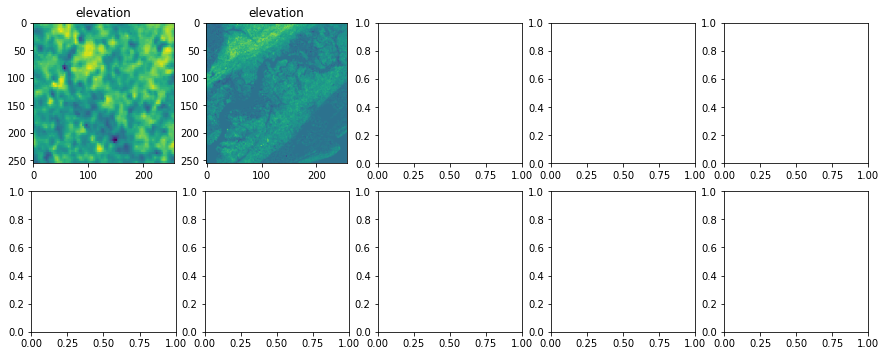

In [ ]:
import os
from osgeo import gdal
import matplotlib.pyplot as plt

# Just needed in case you'd like to append it to an array
data = []

fig = plt.figure(figsize=(15,15))
# ax1 = fig.add_subplot(1, 2, 1)
# ax2 = fig.add_subplot(1, 2, 2)


ax = [None] * 10

# https://howtothink.readthedocs.io/en/latest/PvL_H.html
for i in range(1,11):
  ax[i-1] = fig.add_subplot(5, 5, i) 

count = 0
for filename in os.listdir(local_download_path):
    
  if filename.endswith("tif"): 
      print(filename)
      try:
        dataset = gdal.Open(local_download_path+filename, gdal.GA_ReadOnly) 
        # Note GetRasterBand() takes band no. starting from 1 not 0
        band = dataset.GetRasterBand(1)
        arr = band.ReadAsArray()
        ax[count].imshow(arr)
        ax[count].set_title(filename.split("_")[-2])
        # plt.imshow(arr)
        # dataset.GetGeoTransform()
        print("({},{})".format(dataset.GetRasterBand(1).XSize, dataset.GetRasterBand(1).YSize))
      except Exception as e:
        print(e)
  count += 1

plt.show()